In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import pos_tag
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [3]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [4]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.columns = ['text', 'author']
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [157]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(3000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
# def bow_features(sentences, common_words):
#     counts = pd.DataFrame(columns=common_words)
#     i = 0
#     for sentence in sentences.iloc[:,0]:
#         # repeat this for every sentence
#         x = pd.Series(sentence).value_counts()
#         x = x[pd.Series([str(x) for x in x.index]).isin(common_words).values]
#         counts.loc[i,:] = 0
#         counts.loc[i,[str(x) for x in x.index]] = x.values
#         i += 1
#         if i % 500 == 0:
#                 print("Processing row {}".format(i))
#         return counts

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

**Bag of Words**

In [229]:
counts = pd.DataFrame(columns=common_words)
i = 0
for sentence in sentences.iloc[:,0]:
    # repeat this for every sentence
    x = pd.Series(sentence).value_counts()
    x = x[pd.Series([str(x) for x in x.index]).isin(common_words).values]
    counts.loc[i,:] = 0
    counts.loc[i,[str(x) for x in x.index]] = x.values
    i += 1
    if i % 300 == 0:
            print("Processing row {}".format(i))

Processing row 300
Processing row 600
Processing row 900
Processing row 1200
Processing row 1500
Processing row 1800
Processing row 2100
Processing row 2400
Processing row 2700
Processing row 3000
Processing row 3300
Processing row 3600
Processing row 3900
Processing row 4200
Processing row 4500
Processing row 4800
Processing row 5100


In [233]:
# create target variable
Y = (sentences.author == 'Austen').astype(int).values
X = counts.astype(int).values

In [239]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9793103448275862

Test set score: 0.7659774436090225


## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [240]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3190, 3921) (3190,)
Training set score: 0.9206896551724137

Test set score: 0.8369360902255639


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [48]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.8213166144200627

Test set score: 0.7796052631578947


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data:

In [163]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [171]:
# Parse our cleaned data.
emma_doc = nlp(emma)
emma_sents = [sent for sent in emma_doc.sents]
emma_sents = emma_sents[:len(alice_sents)]

In [172]:
# count the words
counts2 = pd.DataFrame(columns=common_words)
i = 0
for sentence in emma_sents:
    # repeat this for every sentence
    x = pd.Series(sentence).value_counts()
    x = x[pd.Series([str(x) for x in x.index]).isin(common_words).values]
    counts2.loc[i,:] = 0
    counts2.loc[i,[str(x) for x in x.index]] = x.values
    i += 1
    if i % 300 == 0:
            print("Processing row {}".format(i))

Processing row 300
Processing row 600
Processing row 900
Processing row 1200
Processing row 1500


In [241]:
# add the emma stuff to the X_test and y_test matrices
X_test = np.concatenate((X_test, counts2.astype(int).values))
y_test = np.concatenate((y_test, np.ones((counts2.shape[0], ))))

In [242]:
# Model.
print('\nTest set score:', lr.score(X_test, y_test))
lr_Emma_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_Emma_predicted)


Test set score: 0.8567289965762444


col_0,0,1
row_0,,
0.0,435,221
1.0,323,2818


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 93%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 90%.  

# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

**Feature Engineering**

In [175]:
# get average sentence length
sentence_lengths = [len(re.findall(r'\w+',str(sent))) for sent in sentences.iloc[:,0]]
sentence_lengths2 = [len(re.findall(r'\w+',str(sent))) for sent in emma_sents]
sentence_lengths = pd.Series(sentence_lengths + sentence_lengths2)

In [269]:
all_counts = counts.append(counts2)
all_counts["sentence_length"] = sentence_lengths

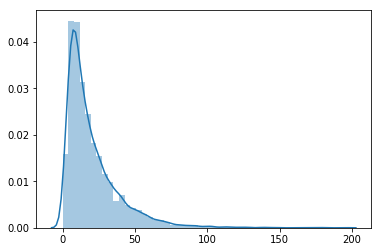

In [224]:
sns.distplot(sentence_lengths)

In [222]:
# average word length
def avrg_count(x):
    total_chars = len(re.sub(r'[^a-zA-Z0-9]', '', x))
    num_words = len(re.findall(r'\w+',str(x)))
    if num_words == 0:
        return total_chars
    else:
        return total_chars/float(num_words)
avg_word_lengths = [avrg_count(str(sent)) for sent in sentences.iloc[:,0]]
avg_word_lengths2 = [avrg_count(str(sent)) for sent in emma_sents]
avg_word_lengths = pd.Series(avg_word_lengths+avg_word_lengths2)
all_counts["average_word_length"] = avg_word_lengths

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


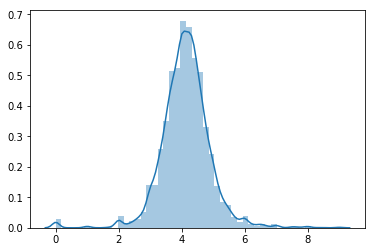

In [223]:
sns.distplot(avg_word_lengths)

In [137]:
# get all possible POS tags
all_tags = set()
for sent in sentences.iloc[:,0]:
    for token in nlp(sent.string):
        all_tags.add(token.pos_)

In [189]:
pos_tags = pd.DataFrame(columns=list(all_tags))
i = 0
for sent in sentences.iloc[:,0]:
    list_pos = []
    for token in nlp(sent.string):
        list_pos.append(token.pos_)    
    counts = pd.Series(list_pos).value_counts()

    for pos in counts.index:
        pos_tags.loc[i,pos] = counts.loc[pos]
    i+=1
    if i % 300 == 0:
            print("Processing row {}".format(i))

Processing row 300
Processing row 600
Processing row 900
Processing row 1200
Processing row 1500
Processing row 1800
Processing row 2100
Processing row 2400
Processing row 2700
Processing row 3000
Processing row 3300
Processing row 3600
Processing row 3900
Processing row 4200
Processing row 4500
Processing row 4800
Processing row 5100


In [188]:
pos_tags2 = pd.DataFrame(columns=list(all_tags))
i = 0
for sent in emma_sents:
    list_pos = []
    for token in nlp(sent.string):
        list_pos.append(token.pos_)    
    counts = pd.Series(list_pos).value_counts()

    for pos in counts.index:
        pos_tags2.loc[i,pos] = counts.loc[pos]
    i+=1
    if i % 300 == 0:
            print("Processing row {}".format(i))

Processing row 300
Processing row 600
Processing row 900
Processing row 1200
Processing row 1500


In [199]:
pos_tags.fillna(0, inplace=True)
pos_tags2.fillna(0, inplace=True)
pos = pos_tags.append(pos_tags2)

In [274]:
pos.index = all_counts.index

In [205]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Polarity
'''
    INPUT: single sentence 
    OUTPUT: list of values: [negative, neutral, positive, compound]
'''
def nltk_sentiment(sentence, return_list = True):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence.string)
    # score will look like:
    # {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.3612}
    if return_list:
        # [0.0, 0.667, 0.333, 0.3612]
        score = [ item[1] for item in score.items() ]
        return score[0], score[1], score[2], score[3]
    else:
        return score

In [214]:
polarity_scores = []
for sentence in sentences.iloc[:,0]:
    polarity_scores.append(nltk_sentiment(sentence))
    polarity_scores2 = []
for sentence in emma_sents:
    polarity_scores2.append(nltk_sentiment(sentence))
scores = pd.DataFrame(polarity_scores + polarity_scores2)

In [283]:
scores.index = all_counts.index

In [284]:
all_counts = pd.concat([all_counts, pos, scores], axis=1)

In [150]:
# now re-split

NOUN    1
dtype: int64

In [302]:
Y = (sentences.author == "Austen").astype(int)
Y = np.concatenate((Y, np.ones((1669, ))))

X = all_counts.astype(int)

# Evaluation

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

In [311]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(4192, 3941) (4192,)
Training set score: 0.9324904580152672

Test set score: 0.8633273703041144
